In [0]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime

seed = 42
np.random.seed(seed)
% matplotlib inline

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
os.chdir('/content')
from google.colab import files
keys = files.upload()

Saving ssh.tar.gz to ssh.tar.gz


In [4]:
!rm -rf /root/.ssh
!mkdir /root/.ssh

!tar xvzf ssh.tar.gz

!cp ssh-colab/* /root/.ssh && rm -rf ssh-colab
!chmod 700 /root/.ssh

!touch /root/.ssh/known_hosts
!ssh-keyscan github.com >> /root/.ssh/known_hosts
!chmod 644 /root/.ssh/known_hosts

ssh-colab/
ssh-colab/config
ssh-colab/id_rsa_colab
ssh-colab/id_rsa_colab.pub
# github.com:22 SSH-2.0-babeld-d48c3acd
# github.com:22 SSH-2.0-babeld-d48c3acd
# github.com:22 SSH-2.0-babeld-d48c3acd


In [5]:
!ssh-agent /bin/bash

bash: cannot set terminal process group (139): Inappropriate ioctl for device
bash: no job control in this shell
]0;root@ab06ed6c7784: /contentroot@ab06ed6c7784:/content# ssh-add /root/.ssh/id_rsa_colab
Identity added: /root/.ssh/id_rsa_colab (/root/.ssh/id_rsa_colab)
]0;root@ab06ed6c7784: /contentroot@ab06ed6c7784:/content# ssh-add -l
2048 SHA256:SpU/DuMOwLsZmS9hdQfImWud0o5YhuYTkxLgNOtF1aA /root/.ssh/id_rsa_colab (RSA)
]0;root@ab06ed6c7784: /contentroot@ab06ed6c7784:/content# exit
exit


In [0]:
!git config --global user.email 'rashmi.raviprasad@gmail.com'
!git config --global user.name 'rashmi-raviprasad'

In [0]:
IMAGE_DIRECTORY = '/content/drive/My Drive/Springboard DS Course/CAPSTONE 2/IMAGES/NEW_FINAL_PICS'
REPOSITORY = '/content/drive/My Drive/Springboard DS Course/REPOSITORY/springboard'
os.chdir(REPOSITORY+'/faces_capstone2')

In [0]:
from keras.models import Sequential

class Decoder(Sequential):
  def load_data(self, cat_dir, face_dir, n_images=1000):
    self.imgs = []
    cat_samples = np.random.choice(cat_dir, int(n_images/2), replace=False)
    face_samples = np.random.choice(face_dir, int(n_images/2), replace=False)
    all_samples = np.concatenate((cat_samples, face_samples))
    try:
      for file in tqdm(all_samples):
        fn = IMAGE_DIRECTORY + '/' + file
        img = cv2.imread(fn)
        rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        self.imgs.append(rgb_image.astype(np.float32) / 255.)
    except:
      print(file)
    np.random.shuffle(self.imgs)
    x_all = np.arange(len(self.imgs))
    self.all_dim = np.asarray(self.imgs).shape[0]
    X = np.array(x_all)
    y = np.array(self.imgs)
    return X, y
  def build_model(self, n_components, model_filename, log_filename, n_dim=1000, decoder=None):
    os.chdir(REPOSITORY+'/faces_capstone2')
    decoder = Sequential()
    decoder.add(Embedding(input_dim=n_dim, output_dim=n_components, input_length=1))
    decoder.add(Flatten())
    decoder.add(Reshape((1, 1, n_components)))
    decoder.add(Conv2DTranspose(filters=64, kernel_size=3, strides=1, activation='relu'))
    decoder.add(Conv2DTranspose(filters=64, kernel_size=3, strides=1, activation='relu'))
    decoder.add(Conv2DTranspose(filters=32, kernel_size=3, strides=1, activation='relu'))
    decoder.add(Conv2DTranspose(filters=32, kernel_size=3, strides=2, activation='relu'))
    decoder.add(Conv2DTranspose(filters=16, kernel_size=3, strides=2, activation='relu'))
    decoder.add(Conv2DTranspose(filters=16, kernel_size=3, strides=2, activation='relu'))
    decoder.add(Conv2DTranspose(filters=8, kernel_size=3, strides=2, activation='relu'))
    decoder.add(Conv2DTranspose(filters=3, kernel_size=4, strides=2, activation='sigmoid'))
    decoder.compile(optimizer='adam', loss='mse')
    self.model_filename = model_filename
    decoder.save(self.model_filename)
    self.decoder = decoder
    self.log_filename = log_filename
    train_log = pd.DataFrame(columns=['Date', 'Run_Number', 'Num_Epochs_Tot', 
                                      'Train_Loss', 'Valid_Loss'])
    init_data = {'Date':datetime.now(), 'Run_Number':0, 'Num_Epochs_Tot':0, 'Train_Loss':None, 
                 'Valid_Loss':None}
    train_log.loc[len(train_log)] = list(init_data.values())
    train_log.to_csv(self.log_filename, index=False)
  def fit_model(self, X, y, i, batch_size, n_epochs):
    os.chdir(REPOSITORY+'/faces_capstone2')
    model = load_model(self.model_filename)
    model_hist = model.fit(X, y, batch_size=batch_size, epochs=n_epochs, validation_split=0.2)
    model.save(self.model_filename)
    train_log = pd.read_csv(self.log_filename)
    data_dict = {'Date':datetime.now(), 'Run_Number':i+1, 'Num_Epochs_Tot':n_epochs*(i+1), 
                 'Train_Loss':model_hist.history['loss'][-1], 'Valid_Loss':model_hist.history['val_loss'][-1]}
    train_log.loc[len(train_log)] = list(data_dict.values())
    train_log.to_csv(self.log_filename, index=False)
  def predict_model(self, X, y, batch_size):
    os.chdir(REPOSITORY+'/faces_capstone2')
    self.decoder = load_model(self.model_filename)
    return self.decoder.predict(X, batch_size=batch_size)

In [0]:
def save_to_git(commit_msg):
  os.chdir(REPOSITORY)
  os.environ['MSG'] = commit_msg
  !git pull
  !git add .
  !git commit -m $MSG
  !git push

In [37]:
decoder_model = Decoder()
#decoder_model.load_data()

img_list = os.listdir(IMAGE_DIRECTORY)
cat_dir = []
face_dir = []
for filename in tqdm(img_list):
  if '_' in filename:
    cat_dir.append(filename)
  else:
    face_dir.append(filename)

print(len(cat_dir), len(face_dir))


100%|██████████| 56709/56709 [00:00<00:00, 2481997.51it/s]

9908 46801


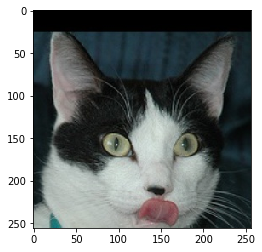

5000


In [0]:
PIC = np.random.choice(5000)
plt.imshow(decoder_model.imgs[PIC])
plt.show()
print(len(decoder_model.imgs))

In [0]:
#from keras.models import Sequential
from keras.layers import Activation, Input, Flatten, Reshape
from keras.layers.convolutional import Conv2DTranspose
from keras.layers.embeddings import Embedding
from keras.callbacks import TensorBoard
from keras import backend as K
K.set_image_data_format('channels_last')
K.clear_session()

In [0]:
BATCH_SIZE = 32 #make it like 32 or 64 or something
N_COMPONENTS = 100
MODEL_FN = 'decoder.h5'
LOGS_FN = 'train_log.csv'
N_EPOCHS = 20

decoder_model.build_model(N_COMPONENTS, MODEL_FN, LOGS_FN, n_dim=500)

In [40]:
from keras.models import load_model

#codeparade had 1769 images, augmented them to make 35,380 samples.
#he used 2000 epochs, so tot num of imgs seen by his network was 70,760,000.
#I am using pulls of 1000 imgs and 20 epochs per pull. In order to
#match num of imgs seen by network to his, I need to pull from the 
#dataset 3,538 times.

N_IMAGES = 500
N_LOOPS = 20
for i in range(N_LOOPS):
  print('Loading %d images' % N_IMAGES)
  X, y = decoder_model.load_data(cat_dir, face_dir, n_images=N_IMAGES)
  print('Training Batch # %d' % (i+1))
  decoder_model.fit_model(X, y, i, BATCH_SIZE, N_EPOCHS)
  message = 'trained %d of %d epochs' % (N_EPOCHS*(i+1), N_EPOCHS*N_LOOPS)
  message = message.replace(' ', '_')
  #save_to_git(message)
  print('Trained %d epochs for total of %d epochs' % (N_EPOCHS, N_EPOCHS*(i+1)))


  0%|          | 0/500 [00:00<?, ?it/s]

Loading 500 images


100%|██████████| 500/500 [04:04<00:00,  2.04it/s]


Training Batch # 1
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 1s 3ms/step - loss: 0.0746 - val_loss: 0.0787
Epoch 2/20
400/400 [==============================] - 0s 945us/step - loss: 0.0737 - val_loss: 0.0774
Epoch 3/20
400/400 [==============================] - 0s 931us/step - loss: 0.0720 - val_loss: 0.0746
Epoch 4/20
400/400 [==============================] - 0s 957us/step - loss: 0.0700 - val_loss: 0.0727
Epoch 5/20
400/400 [==============================] - 0s 961us/step - loss: 0.0693 - val_loss: 0.0721
Epoch 6/20
400/400 [==============================] - 0s 929us/step - loss: 0.0690 - val_loss: 0.0718
Epoch 7/20
400/400 [==============================] - 0s 956us/step - loss: 0.0689 - val_loss: 0.0716
Epoch 8/20
400/400 [==============================] - 0s 929us/step - loss: 0.0688 - val_loss: 0.0716
Epoch 9/20
400/400 [==============================] - 0s 942us/step - loss: 0.0687 - val_loss: 0.0714
Epoch 10/20
400/400

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 20 epochs
Loading 500 images


100%|██████████| 500/500 [03:54<00:00,  2.13it/s]


Training Batch # 2
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 1s 2ms/step - loss: 0.0733 - val_loss: 0.0694
Epoch 2/20
400/400 [==============================] - 0s 944us/step - loss: 0.0656 - val_loss: 0.0687
Epoch 3/20
400/400 [==============================] - 0s 947us/step - loss: 0.0643 - val_loss: 0.0678
Epoch 4/20
400/400 [==============================] - 0s 956us/step - loss: 0.0630 - val_loss: 0.0676
Epoch 5/20
400/400 [==============================] - 0s 945us/step - loss: 0.0617 - val_loss: 0.0676
Epoch 6/20
400/400 [==============================] - 0s 952us/step - loss: 0.0585 - val_loss: 0.0680
Epoch 7/20
400/400 [==============================] - 0s 953us/step - loss: 0.0521 - val_loss: 0.0709
Epoch 8/20
400/400 [==============================] - 0s 954us/step - loss: 0.0457 - val_loss: 0.0705
Epoch 9/20
400/400 [==============================] - 0s 943us/step - loss: 0.0405 - val_loss: 0.0717
Epoch 10/20
400/400

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 40 epochs
Loading 500 images


100%|██████████| 500/500 [03:12<00:00,  2.60it/s]


Training Batch # 3
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 1s 2ms/step - loss: 0.0773 - val_loss: 0.0694
Epoch 2/20
400/400 [==============================] - 0s 969us/step - loss: 0.0645 - val_loss: 0.0671
Epoch 3/20
400/400 [==============================] - 0s 963us/step - loss: 0.0630 - val_loss: 0.0664
Epoch 4/20
400/400 [==============================] - 0s 961us/step - loss: 0.0604 - val_loss: 0.0668
Epoch 5/20
400/400 [==============================] - 0s 954us/step - loss: 0.0558 - val_loss: 0.0671
Epoch 6/20
400/400 [==============================] - 0s 972us/step - loss: 0.0477 - val_loss: 0.0705
Epoch 7/20
400/400 [==============================] - 0s 963us/step - loss: 0.0398 - val_loss: 0.0722
Epoch 8/20
400/400 [==============================] - 0s 961us/step - loss: 0.0345 - val_loss: 0.0737
Epoch 9/20
400/400 [==============================] - 0s 973us/step - loss: 0.0313 - val_loss: 0.0746
Epoch 10/20
400/400

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 60 epochs
Loading 500 images


100%|██████████| 500/500 [03:24<00:00,  2.45it/s]


Training Batch # 4
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 1s 3ms/step - loss: 0.0863 - val_loss: 0.0709
Epoch 2/20
400/400 [==============================] - 0s 976us/step - loss: 0.0678 - val_loss: 0.0692
Epoch 3/20
400/400 [==============================] - 0s 988us/step - loss: 0.0660 - val_loss: 0.0695
Epoch 4/20
400/400 [==============================] - 0s 991us/step - loss: 0.0636 - val_loss: 0.0701
Epoch 5/20
400/400 [==============================] - 0s 977us/step - loss: 0.0593 - val_loss: 0.0708
Epoch 6/20
400/400 [==============================] - 0s 975us/step - loss: 0.0521 - val_loss: 0.0732
Epoch 7/20
400/400 [==============================] - 0s 972us/step - loss: 0.0443 - val_loss: 0.0792
Epoch 8/20
400/400 [==============================] - 0s 969us/step - loss: 0.0380 - val_loss: 0.0774
Epoch 9/20
400/400 [==============================] - 0s 982us/step - loss: 0.0338 - val_loss: 0.0794
Epoch 10/20
400/400

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 80 epochs
Loading 500 images


100%|██████████| 500/500 [03:26<00:00,  2.42it/s]


Training Batch # 5
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 1s 3ms/step - loss: 0.0875 - val_loss: 0.0668
Epoch 2/20
400/400 [==============================] - 0s 975us/step - loss: 0.0658 - val_loss: 0.0662
Epoch 3/20
400/400 [==============================] - 0s 981us/step - loss: 0.0638 - val_loss: 0.0660
Epoch 4/20
400/400 [==============================] - 0s 957us/step - loss: 0.0613 - val_loss: 0.0669
Epoch 5/20
400/400 [==============================] - 0s 962us/step - loss: 0.0570 - val_loss: 0.0688
Epoch 6/20
400/400 [==============================] - 0s 957us/step - loss: 0.0494 - val_loss: 0.0693
Epoch 7/20
400/400 [==============================] - 0s 972us/step - loss: 0.0422 - val_loss: 0.0727
Epoch 8/20
400/400 [==============================] - 0s 965us/step - loss: 0.0367 - val_loss: 0.0744
Epoch 9/20
400/400 [==============================] - 0s 982us/step - loss: 0.0328 - val_loss: 0.0750
Epoch 10/20
400/400

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 100 epochs
Loading 500 images


100%|██████████| 500/500 [03:36<00:00,  2.31it/s]


Training Batch # 6
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 1s 3ms/step - loss: 0.0874 - val_loss: 0.0696
Epoch 2/20
400/400 [==============================] - 0s 951us/step - loss: 0.0639 - val_loss: 0.0667
Epoch 3/20
400/400 [==============================] - 0s 954us/step - loss: 0.0616 - val_loss: 0.0671
Epoch 4/20
400/400 [==============================] - 0s 953us/step - loss: 0.0585 - val_loss: 0.0688
Epoch 5/20
400/400 [==============================] - 0s 958us/step - loss: 0.0528 - val_loss: 0.0701
Epoch 6/20
400/400 [==============================] - 0s 951us/step - loss: 0.0457 - val_loss: 0.0727
Epoch 7/20
400/400 [==============================] - 0s 949us/step - loss: 0.0398 - val_loss: 0.0734
Epoch 8/20
400/400 [==============================] - 0s 983us/step - loss: 0.0354 - val_loss: 0.0737
Epoch 9/20
400/400 [==============================] - 0s 953us/step - loss: 0.0324 - val_loss: 0.0747
Epoch 10/20
400/400

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 120 epochs
Loading 500 images


100%|██████████| 500/500 [03:18<00:00,  2.52it/s]


Training Batch # 7
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 1s 3ms/step - loss: 0.0833 - val_loss: 0.0709
Epoch 2/20
400/400 [==============================] - 0s 971us/step - loss: 0.0618 - val_loss: 0.0668
Epoch 3/20
400/400 [==============================] - 0s 951us/step - loss: 0.0589 - val_loss: 0.0673
Epoch 4/20
400/400 [==============================] - 0s 962us/step - loss: 0.0549 - val_loss: 0.0692
Epoch 5/20
400/400 [==============================] - 0s 962us/step - loss: 0.0495 - val_loss: 0.0733
Epoch 6/20
400/400 [==============================] - 0s 967us/step - loss: 0.0436 - val_loss: 0.0785
Epoch 7/20
400/400 [==============================] - 0s 958us/step - loss: 0.0382 - val_loss: 0.0797
Epoch 8/20
400/400 [==============================] - 0s 963us/step - loss: 0.0343 - val_loss: 0.0816
Epoch 9/20
400/400 [==============================] - 0s 960us/step - loss: 0.0313 - val_loss: 0.0812
Epoch 10/20
400/400

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 140 epochs
Loading 500 images


100%|██████████| 500/500 [03:07<00:00,  2.67it/s]


Training Batch # 8
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 1s 3ms/step - loss: 0.0861 - val_loss: 0.0710
Epoch 2/20
400/400 [==============================] - 0s 959us/step - loss: 0.0629 - val_loss: 0.0702
Epoch 3/20
400/400 [==============================] - 0s 968us/step - loss: 0.0603 - val_loss: 0.0698
Epoch 4/20
400/400 [==============================] - 0s 973us/step - loss: 0.0560 - val_loss: 0.0696
Epoch 5/20
400/400 [==============================] - 0s 978us/step - loss: 0.0502 - val_loss: 0.0712
Epoch 6/20
400/400 [==============================] - 0s 963us/step - loss: 0.0438 - val_loss: 0.0746
Epoch 7/20
400/400 [==============================] - 0s 964us/step - loss: 0.0387 - val_loss: 0.0788
Epoch 8/20
400/400 [==============================] - 0s 981us/step - loss: 0.0348 - val_loss: 0.0790
Epoch 9/20
400/400 [==============================] - 0s 972us/step - loss: 0.0318 - val_loss: 0.0796
Epoch 10/20
400/400

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 160 epochs
Loading 500 images


100%|██████████| 500/500 [03:08<00:00,  2.65it/s]


Training Batch # 9
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 1s 3ms/step - loss: 0.0867 - val_loss: 0.0694
Epoch 2/20
400/400 [==============================] - 0s 974us/step - loss: 0.0631 - val_loss: 0.0675
Epoch 3/20
400/400 [==============================] - 0s 973us/step - loss: 0.0605 - val_loss: 0.0682
Epoch 4/20
400/400 [==============================] - 0s 988us/step - loss: 0.0573 - val_loss: 0.0669
Epoch 5/20
400/400 [==============================] - 0s 967us/step - loss: 0.0528 - val_loss: 0.0700
Epoch 6/20
400/400 [==============================] - 0s 981us/step - loss: 0.0464 - val_loss: 0.0757
Epoch 7/20
400/400 [==============================] - 0s 968us/step - loss: 0.0405 - val_loss: 0.0831
Epoch 8/20
400/400 [==============================] - 0s 965us/step - loss: 0.0361 - val_loss: 0.0837
Epoch 9/20
400/400 [==============================] - 0s 966us/step - loss: 0.0328 - val_loss: 0.0881
Epoch 10/20
400/400

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 180 epochs
Loading 500 images


100%|██████████| 500/500 [03:24<00:00,  2.44it/s]


Training Batch # 10
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 1s 4ms/step - loss: 0.0927 - val_loss: 0.0666
Epoch 2/20
400/400 [==============================] - 0s 980us/step - loss: 0.0666 - val_loss: 0.0658
Epoch 3/20
400/400 [==============================] - 0s 975us/step - loss: 0.0632 - val_loss: 0.0657
Epoch 4/20
400/400 [==============================] - 0s 975us/step - loss: 0.0593 - val_loss: 0.0657
Epoch 5/20
400/400 [==============================] - 0s 966us/step - loss: 0.0542 - val_loss: 0.0684
Epoch 6/20
400/400 [==============================] - 0s 960us/step - loss: 0.0478 - val_loss: 0.0712
Epoch 7/20
400/400 [==============================] - 0s 972us/step - loss: 0.0420 - val_loss: 0.0731
Epoch 8/20
400/400 [==============================] - 0s 969us/step - loss: 0.0371 - val_loss: 0.0750
Epoch 9/20
400/400 [==============================] - 0s 968us/step - loss: 0.0335 - val_loss: 0.0774
Epoch 10/20
400/40

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 200 epochs
Loading 500 images


100%|██████████| 500/500 [03:10<00:00,  2.62it/s]


Training Batch # 11
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 2s 4ms/step - loss: 0.0905 - val_loss: 0.0716
Epoch 2/20
400/400 [==============================] - 0s 982us/step - loss: 0.0635 - val_loss: 0.0693
Epoch 3/20
400/400 [==============================] - 0s 994us/step - loss: 0.0606 - val_loss: 0.0716
Epoch 4/20
400/400 [==============================] - 0s 967us/step - loss: 0.0565 - val_loss: 0.0700
Epoch 5/20
400/400 [==============================] - 0s 970us/step - loss: 0.0508 - val_loss: 0.0724
Epoch 6/20
400/400 [==============================] - 0s 965us/step - loss: 0.0442 - val_loss: 0.0777
Epoch 7/20
400/400 [==============================] - 0s 978us/step - loss: 0.0389 - val_loss: 0.0799
Epoch 8/20
400/400 [==============================] - 0s 971us/step - loss: 0.0347 - val_loss: 0.0806
Epoch 9/20
400/400 [==============================] - 0s 974us/step - loss: 0.0317 - val_loss: 0.0816
Epoch 10/20
400/40

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 220 epochs
Loading 500 images


100%|██████████| 500/500 [03:16<00:00,  2.55it/s]


Training Batch # 12
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 2s 4ms/step - loss: 0.0897 - val_loss: 0.0663
Epoch 2/20
400/400 [==============================] - 0s 998us/step - loss: 0.0629 - val_loss: 0.0654
Epoch 3/20
400/400 [==============================] - 0s 995us/step - loss: 0.0592 - val_loss: 0.0649
Epoch 4/20
400/400 [==============================] - 0s 993us/step - loss: 0.0551 - val_loss: 0.0655
Epoch 5/20
400/400 [==============================] - 0s 994us/step - loss: 0.0494 - val_loss: 0.0670
Epoch 6/20
400/400 [==============================] - 0s 997us/step - loss: 0.0435 - val_loss: 0.0686
Epoch 7/20
400/400 [==============================] - 0s 988us/step - loss: 0.0384 - val_loss: 0.0711
Epoch 8/20
400/400 [==============================] - 0s 989us/step - loss: 0.0343 - val_loss: 0.0722
Epoch 9/20
400/400 [==============================] - 0s 998us/step - loss: 0.0314 - val_loss: 0.0731
Epoch 10/20
400/40

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 240 epochs
Loading 500 images


100%|██████████| 500/500 [03:13<00:00,  2.58it/s]


Training Batch # 13
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 2s 5ms/step - loss: 0.0879 - val_loss: 0.0721
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0598 - val_loss: 0.0686
Epoch 3/20
400/400 [==============================] - 0s 997us/step - loss: 0.0552 - val_loss: 0.0674
Epoch 4/20
400/400 [==============================] - 0s 989us/step - loss: 0.0509 - val_loss: 0.0680
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0457 - val_loss: 0.0686
Epoch 6/20
400/400 [==============================] - 0s 991us/step - loss: 0.0406 - val_loss: 0.0695
Epoch 7/20
400/400 [==============================] - 0s 988us/step - loss: 0.0364 - val_loss: 0.0705
Epoch 8/20
400/400 [==============================] - 0s 989us/step - loss: 0.0329 - val_loss: 0.0707
Epoch 9/20
400/400 [==============================] - 0s 996us/step - loss: 0.0303 - val_loss: 0.0712
Epoch 10/20
400/400 [=

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 260 epochs
Loading 500 images


100%|██████████| 500/500 [03:00<00:00,  2.77it/s]


Training Batch # 14
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 2s 5ms/step - loss: 0.0930 - val_loss: 0.0682
Epoch 2/20
400/400 [==============================] - 0s 962us/step - loss: 0.0649 - val_loss: 0.0655
Epoch 3/20
400/400 [==============================] - 0s 977us/step - loss: 0.0590 - val_loss: 0.0648
Epoch 4/20
400/400 [==============================] - 0s 988us/step - loss: 0.0555 - val_loss: 0.0648
Epoch 5/20
400/400 [==============================] - 0s 979us/step - loss: 0.0508 - val_loss: 0.0658
Epoch 6/20
400/400 [==============================] - 0s 977us/step - loss: 0.0454 - val_loss: 0.0670
Epoch 7/20
400/400 [==============================] - 0s 976us/step - loss: 0.0401 - val_loss: 0.0678
Epoch 8/20
400/400 [==============================] - 0s 963us/step - loss: 0.0358 - val_loss: 0.0688
Epoch 9/20
400/400 [==============================] - 0s 965us/step - loss: 0.0327 - val_loss: 0.0695
Epoch 10/20
400/40

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 280 epochs
Loading 500 images


100%|██████████| 500/500 [03:12<00:00,  2.59it/s]


Training Batch # 15
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 2s 5ms/step - loss: 0.0921 - val_loss: 0.0697
Epoch 2/20
400/400 [==============================] - 0s 990us/step - loss: 0.0624 - val_loss: 0.0682
Epoch 3/20
400/400 [==============================] - 0s 991us/step - loss: 0.0580 - val_loss: 0.0683
Epoch 4/20
400/400 [==============================] - 0s 989us/step - loss: 0.0527 - val_loss: 0.0701
Epoch 5/20
400/400 [==============================] - 0s 975us/step - loss: 0.0471 - val_loss: 0.0712
Epoch 6/20
400/400 [==============================] - 0s 988us/step - loss: 0.0414 - val_loss: 0.0725
Epoch 7/20
400/400 [==============================] - 0s 986us/step - loss: 0.0368 - val_loss: 0.0729
Epoch 8/20
400/400 [==============================] - 0s 985us/step - loss: 0.0331 - val_loss: 0.0733
Epoch 9/20
400/400 [==============================] - 0s 982us/step - loss: 0.0305 - val_loss: 0.0744
Epoch 10/20
400/40

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 300 epochs
Loading 500 images


100%|██████████| 500/500 [03:02<00:00,  2.74it/s]


Training Batch # 16
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 2s 5ms/step - loss: 0.0927 - val_loss: 0.0683
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0613 - val_loss: 0.0666
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0564 - val_loss: 0.0665
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0521 - val_loss: 0.0671
Epoch 5/20
400/400 [==============================] - 0s 980us/step - loss: 0.0466 - val_loss: 0.0693
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0416 - val_loss: 0.0693
Epoch 7/20
400/400 [==============================] - 0s 996us/step - loss: 0.0375 - val_loss: 0.0700
Epoch 8/20
400/400 [==============================] - 0s 998us/step - loss: 0.0338 - val_loss: 0.0703
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0311 - val_loss: 0.0715
Epoch 10/20
400/400 [=======

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 320 epochs
Loading 500 images


100%|██████████| 500/500 [02:56<00:00,  2.83it/s]


Training Batch # 17
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 2s 5ms/step - loss: 0.0919 - val_loss: 0.0641
Epoch 2/20
400/400 [==============================] - 0s 1000us/step - loss: 0.0616 - val_loss: 0.0638
Epoch 3/20
400/400 [==============================] - 0s 977us/step - loss: 0.0559 - val_loss: 0.0636
Epoch 4/20
400/400 [==============================] - 0s 991us/step - loss: 0.0512 - val_loss: 0.0642
Epoch 5/20
400/400 [==============================] - 0s 979us/step - loss: 0.0458 - val_loss: 0.0647
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0404 - val_loss: 0.0659
Epoch 7/20
400/400 [==============================] - 0s 986us/step - loss: 0.0363 - val_loss: 0.0675
Epoch 8/20
400/400 [==============================] - 0s 974us/step - loss: 0.0329 - val_loss: 0.0670
Epoch 9/20
400/400 [==============================] - 0s 991us/step - loss: 0.0304 - val_loss: 0.0682
Epoch 10/20
400/400

  1%|▏         | 7/500 [00:00<00:07, 64.48it/s]

Trained 20 epochs for total of 340 epochs
Loading 500 images


100%|██████████| 500/500 [02:53<00:00,  2.87it/s]


Training Batch # 18
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 2s 6ms/step - loss: 0.0927 - val_loss: 0.0676
Epoch 2/20
400/400 [==============================] - 0s 991us/step - loss: 0.0622 - val_loss: 0.0668
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0569 - val_loss: 0.0657
Epoch 4/20
400/400 [==============================] - 0s 997us/step - loss: 0.0520 - val_loss: 0.0660
Epoch 5/20
400/400 [==============================] - 0s 994us/step - loss: 0.0464 - val_loss: 0.0672
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0410 - val_loss: 0.0677
Epoch 7/20
400/400 [==============================] - 0s 983us/step - loss: 0.0363 - val_loss: 0.0685
Epoch 8/20
400/400 [==============================] - 0s 988us/step - loss: 0.0328 - val_loss: 0.0697
Epoch 9/20
400/400 [==============================] - 0s 994us/step - loss: 0.0301 - val_loss: 0.0703
Epoch 10/20
400/400 [=

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 360 epochs
Loading 500 images


100%|██████████| 500/500 [02:49<00:00,  2.94it/s]


Training Batch # 19
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 2s 6ms/step - loss: 0.0935 - val_loss: 0.0756
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0619 - val_loss: 0.0725
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0567 - val_loss: 0.0750
Epoch 4/20
400/400 [==============================] - 0s 987us/step - loss: 0.0520 - val_loss: 0.0769
Epoch 5/20
400/400 [==============================] - 0s 987us/step - loss: 0.0464 - val_loss: 0.0836
Epoch 6/20
400/400 [==============================] - 0s 988us/step - loss: 0.0414 - val_loss: 0.0872
Epoch 7/20
400/400 [==============================] - 0s 987us/step - loss: 0.0368 - val_loss: 0.0889
Epoch 8/20
400/400 [==============================] - 0s 981us/step - loss: 0.0332 - val_loss: 0.0939
Epoch 9/20
400/400 [==============================] - 0s 985us/step - loss: 0.0307 - val_loss: 0.0960
Epoch 10/20
400/400 [=

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 380 epochs
Loading 500 images


100%|██████████| 500/500 [03:00<00:00,  2.76it/s]


Training Batch # 20
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 2s 6ms/step - loss: 0.0899 - val_loss: 0.0686
Epoch 2/20
400/400 [==============================] - 0s 984us/step - loss: 0.0598 - val_loss: 0.0661
Epoch 3/20
400/400 [==============================] - 0s 996us/step - loss: 0.0544 - val_loss: 0.0668
Epoch 4/20
400/400 [==============================] - 0s 991us/step - loss: 0.0497 - val_loss: 0.0690
Epoch 5/20
400/400 [==============================] - 0s 978us/step - loss: 0.0439 - val_loss: 0.0731
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0388 - val_loss: 0.0758
Epoch 7/20
400/400 [==============================] - 0s 971us/step - loss: 0.0348 - val_loss: 0.0806
Epoch 8/20
400/400 [==============================] - 0s 983us/step - loss: 0.0316 - val_loss: 0.0812
Epoch 9/20
400/400 [==============================] - 0s 991us/step - loss: 0.0291 - val_loss: 0.0835
Epoch 10/20
400/400 

In [0]:
os.chdir(REPOSITORY+'/faces_capstone2')
compressed = decoder_model.predict_model(X, y, batch_size=BATCH_SIZE)

367


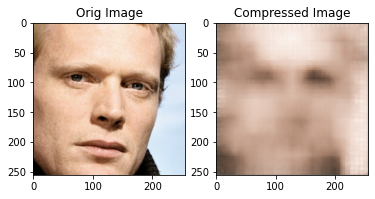

In [56]:
PIC = np.random.choice(500)
print(PIC)
plt.subplot(1,2,1)
plt.imshow(decoder_model.imgs[PIC])
plt.title('Orig Image')

plt.subplot(1,2,2)
plt.imshow(compressed[PIC])
plt.title('Compressed Image')

plt.show()

In [9]:
save_to_git('switched_to_batch_image_loading')

Already up to date.
[master 77e9abc] switched_to_batch_image_loading
 3 files changed, 6 insertions(+), 53 deletions(-)
 rewrite faces_capstone2/decoder.h5 (87%)
 rewrite faces_capstone2/faces_decoder.ipynb (96%)
 rewrite faces_capstone2/train_log.csv (98%)
Counting objects: 6, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 1.45 MiB | 1.22 MiB/s, done.
Total 6 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To github.com:rashmi-raviprasad/springboard.git
   7e379b1..77e9abc  master -> master


In [0]:
os.chdir(REPOSITORY+'/faces_capstone2')
log = pd.read_csv(LOGS_FN)
log.head()

,Date,Run_Number,Num_Epochs_Tot,Train_Loss,Valid_Loss
0,2020-03-10 02:27:40.443648,0,0,NaN,NaN
1,2020-03-10 02:28:16.455108,1,5,0.031323,0.057537
2,2020-03-10 02:28:58.949584,2,10,0.019592,0.059774
3,2020-03-10 02:29:45.312118,3,15,0.015328,0.060629
4,2020-03-10 02:30:29.528276,4,20,0.013094,0.059538


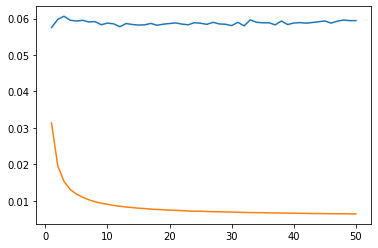

In [0]:
plt.plot(log[['Valid_Loss', 'Train_Loss']])
plt.show()